In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/Shareddrives/IA - Detección de Plagio - 8vo/reto"
!ls

/content/drive/Shareddrives/IA - Detección de Plagio - 8vo/reto
000.java       5449d33c.java	  modelo1.ipynb
001.java       base.csv		  modelo2.ipynb
003.java       classifier.joblib  procesado.ipynb
004.java       CNN.ipynb	  RandomForestClassifier.ipynb
00af3420.java  Identifier.ipynb   tokenizer.joblib
017.java       limpieza.ipynb	  versions
022.java       max_length.joblib  visualizacion.ipynb


In [ ]:
def get_code(text):
    # punctuation = ["_", "-", ".", ":", ",", ";", "(", ")", "?", "¿", "¡", "!", '"', "{", "}", "[", "]", "+", "*", "=", "/", "%", "<", ">"]
    # for i in punctuation:
    #     text = text.replace(i, " ")
    text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    return text

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# Paso 1: Preparación de los datos
data = pd.read_csv('base.csv')
data['Code1'] = data['Code1'].apply(get_code)
data['Code2'] = data['Code2'].apply(get_code)

features = data[['Code1', 'Code2']]
labels = data['verdict']

# Paso 2: División de los datos
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Paso 3: Tokenización y Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['Code1'] + X_train['Code2'])

train_sequences_code1 = tokenizer.texts_to_sequences(X_train['Code1'])
train_sequences_code2 = tokenizer.texts_to_sequences(X_train['Code2'])
test_sequences_code1 = tokenizer.texts_to_sequences(X_test['Code1'])
test_sequences_code2 = tokenizer.texts_to_sequences(X_test['Code2'])

max_length = max(max(len(seq) for seq in train_sequences_code1), max(len(seq) for seq in train_sequences_code2))

train_sequences_code1 = pad_sequences(train_sequences_code1, maxlen=max_length)
train_sequences_code2 = pad_sequences(train_sequences_code2, maxlen=max_length)
test_sequences_code1 = pad_sequences(test_sequences_code1, maxlen=max_length)
test_sequences_code2 = pad_sequences(test_sequences_code2, maxlen=max_length)

# Paso 4: Definición del modelo CNN
embedding_dim = 100
num_filters = 64
filter_sizes = [3, 4, 5]
dropout_rate = 0.5

input1 = Input(shape=(max_length,))
input2 = Input(shape=(max_length,))

embedding = Embedding(len(tokenizer.word_index) + 1, embedding_dim)

conv_blocks = []
for filter_size in filter_sizes:
    conv = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu')
    conv_block1 = conv(embedding(input1))
    conv_block2 = conv(embedding(input2))
    pool1 = GlobalMaxPooling1D()(conv_block1)
    pool2 = GlobalMaxPooling1D()(conv_block2)
    conv_blocks.extend([pool1, pool2])

if len(filter_sizes) > 1:
    merged = concatenate(conv_blocks)
else:
    merged = conv_blocks[0]

dropout = Dropout(dropout_rate)(merged)
dense1 = Dense(64, activation='relu')(dropout)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[input1, input2], outputs=output)

# Paso 5: Compilación y entrenamiento del modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit([train_sequences_code1, train_sequences_code2], y_train, epochs=10, batch_size=64, validation_data=([test_sequences_code1, test_sequences_code2], y_test))

# Paso 6: Evaluación del modelo
loss, accuracy = model.evaluate([test_sequences_code1, test_sequences_code2], y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)


Epoch 1/10
12/12 [==============================] - 136s 11s/step - loss: 0.6057 - acc: 0.7198 - val_loss: 0.5771 - val_acc: 0.7322
Epoch 2/10
12/12 [==============================] - 130s 11s/step - loss: 0.5773 - acc: 0.7225 - val_loss: 0.5733 - val_acc: 0.7322
Epoch 3/10
12/12 [==============================] - 131s 11s/step - loss: 0.5585 - acc: 0.7225 - val_loss: 0.5579 - val_acc: 0.7322
Epoch 4/10
12/12 [==============================] - 132s 11s/step - loss: 0.5522 - acc: 0.7225 - val_loss: 0.5481 - val_acc: 0.7322
Epoch 5/10
12/12 [==============================] - 132s 11s/step - loss: 0.5200 - acc: 0.7280 - val_loss: 0.5307 - val_acc: 0.7432
Epoch 6/10
12/12 [==============================] - 136s 11s/step - loss: 0.4843 - acc: 0.7404 - val_loss: 0.5137 - val_acc: 0.7760
Epoch 7/10
12/12 [==============================] - 160s 13s/step - loss: 0.4355 - acc: 0.7830 - val_loss: 0.4870 - val_acc: 0.7923
Epoch 8/10
12/12 [==============================] - 136s 11s/step - loss: 0.

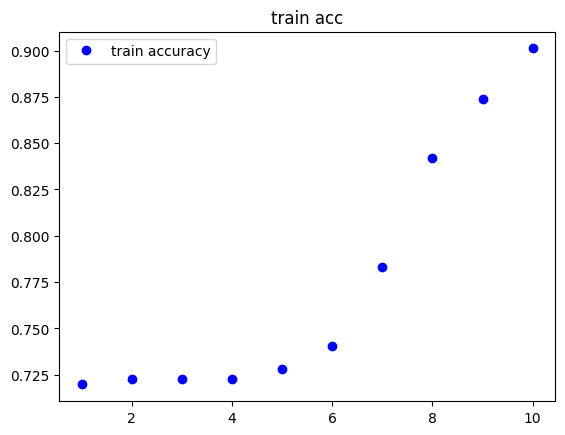

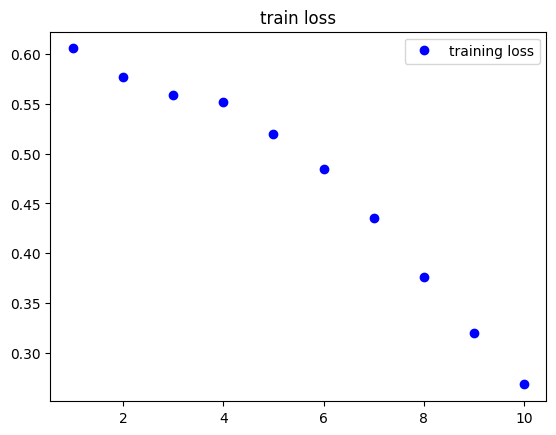

In [7]:
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc,'bo',label='train accuracy')
plt.title('train acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.title('train loss')
plt.legend()

plt.show()

In [12]:
# Paso 7: Predicciones con los datos de prueba
predictions = model.predict([test_sequences_code1, test_sequences_code2])
predictions = np.round(predictions).astype(int)

# Paso 8: Matriz de confusión
confusion_matrix = confusion_matrix(y_test, predictions)
print("Matriz de Confusión:")
print(confusion_matrix)

6/6 [==============================] - 10s 2s/step
Matriz de Confusión:
[[125   9]
 [ 26  23]]


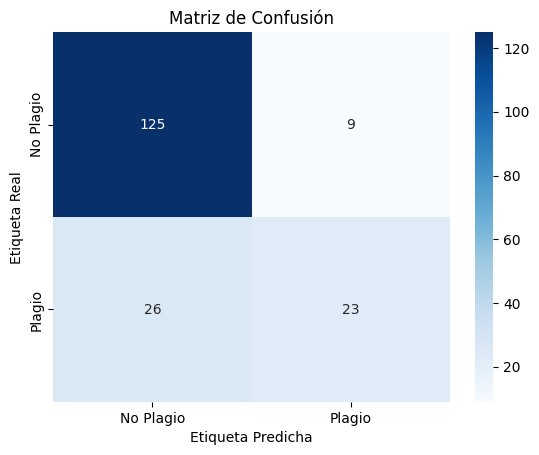

In [15]:
# Paso 9: Generar heatmap
labels = ['No Plagio', 'Plagio']
sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')

plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()